In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#===================== Parameter settings =========================
#for training
algorithms = {
    "LS2IC": "../results/ls2ic",
    "MADQN": "../results/ps_dqn",
    "MADQN-PA": "../results/ps_dqn_a",
    "MF-Q": "../results/meanfield"
}
num_agents = 992 #32*31, geant topolopy is 506 = 23*22

# for testing
# algorithm_dirs = {
#     "LS2IC": "../results/ls2ic",
#     "MADQN": "../results/ps_dqn",
#     "MADQN-PA": "../results/ps_dqn_a",
#     "MF-Q": "../results/meanfield",
#     "DRSIR": "../results/drsir",
#     "OSPF": "../results/ospf"
# }
algorithm_dirs = {
    "LS2IC": "../results/ls2ic",
}

# testing tm id
# tm_files = ["06_eval_metrics.csv", "41_eval_metrics.csv", "73_eval_metrics.csv", "108_eval_metrics.csv", "141_eval_metrics.csv"]
tm_files = ["06_eval_metrics.csv", "41_eval_metrics.csv"]

FileNotFoundError: can't found: ../results/ps_dqn/output.txt

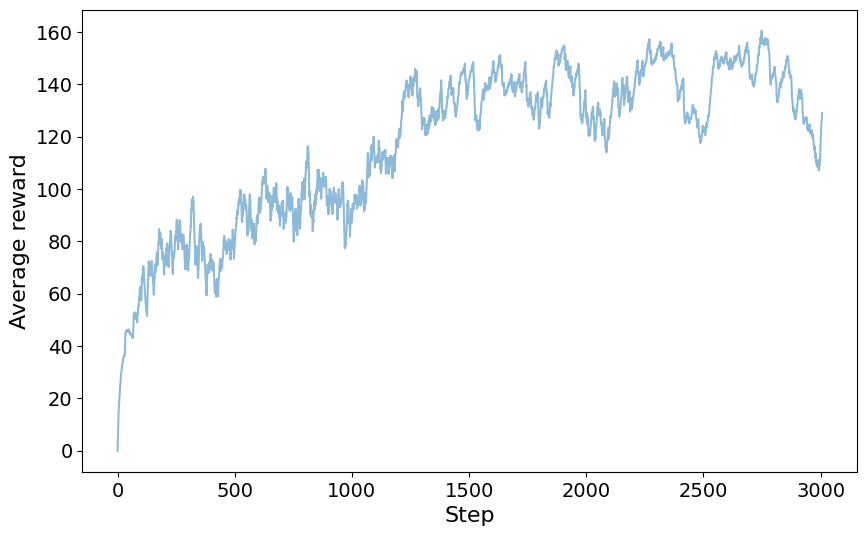

In [3]:
def get_smooth(values, smoothing_factor):
    smoothed = []
    for i, val in enumerate(values):
        if i == 0:
            smoothed.append(val)
        else:
            smoothed.append(val * (1 - smoothing_factor) + smoothed[i - 1] * smoothing_factor)
    return smoothed

def load_rewards_from_file(file_path, divisor=992):
    if not os.path.isfile(file_path):
        raise FileNotFoundError(f"can't found: {file_path}")

    with open(file_path, 'r') as f:
        lines = f.read().splitlines()

    raw_tokens = ",".join(lines).split(',')
    float_rewards = []
    for token in raw_tokens[1:-1]:
        try:
            val = float(token) / divisor
            float_rewards.append(val)
        except ValueError:
            continue
    return float_rewards

def plot_algorithms(algorithms, smoothing_factor=0.95, divisor=992, ylabel="Average reward", output_file="training_reward.svg"):
    plt.rcParams.update({'font.size': 14})
    plt.figure(figsize=(10, 6))
    plt.xlabel('Step', fontsize=16)
    plt.ylabel(ylabel, fontsize=16)

    colors = plt.cm.tab10.colors  # 預設 10 種顏色
    for idx, (label, dir_path) in enumerate(algorithms.items()):
        file_path = os.path.join(dir_path, "output.txt")
        rewards = load_rewards_from_file(file_path, divisor=divisor)
        if not rewards:
            continue
        smoothed = get_smooth(rewards, smoothing_factor)
        steps = np.arange(len(smoothed))
        color = colors[idx % len(colors)]
        plt.plot(steps, smoothed, alpha=0.5, color=color, label=label)

    plt.legend(fontsize=16)
    plt.ylim(bottom=30)
    plt.tight_layout()
    plt.savefig(output_file, format='svg', bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    plot_algorithms(
        algorithms=algorithms,
        smoothing_factor=0.95,
        divisor=num_agents,
        ylabel="Average reward",
        output_file="Training_Reward.svg"
    )


Algorithm LS2IC metrics:
{'06': {'avg_delay': 3.786598978888889, 'avg_packet_loss': 0.0063474611111110696, 'avg_throughput': 79.18078576094946, 'max_link_utilization': 78.19662613526665}, '41': {'avg_delay': 5.484074416666668, 'avg_packet_loss': 0.0073744827777777406, 'avg_throughput': 90.58498839539774, 'max_link_utilization': 91.34757228884999}}
=== avg_delay ===
--- TM = 06 ---
       LS2IC
LS2IC    NaN

--- TM = 41 ---
       LS2IC
LS2IC    NaN

=== avg_packet_loss ===
--- TM = 06 ---
       LS2IC
LS2IC    NaN

--- TM = 41 ---
       LS2IC
LS2IC    NaN

=== avg_throughput ===
--- TM = 06 ---
       LS2IC
LS2IC    NaN

--- TM = 41 ---
       LS2IC
LS2IC    NaN

=== max_link_utilization ===
--- TM = 06 ---
       LS2IC
LS2IC    NaN

--- TM = 41 ---
       LS2IC
LS2IC    NaN



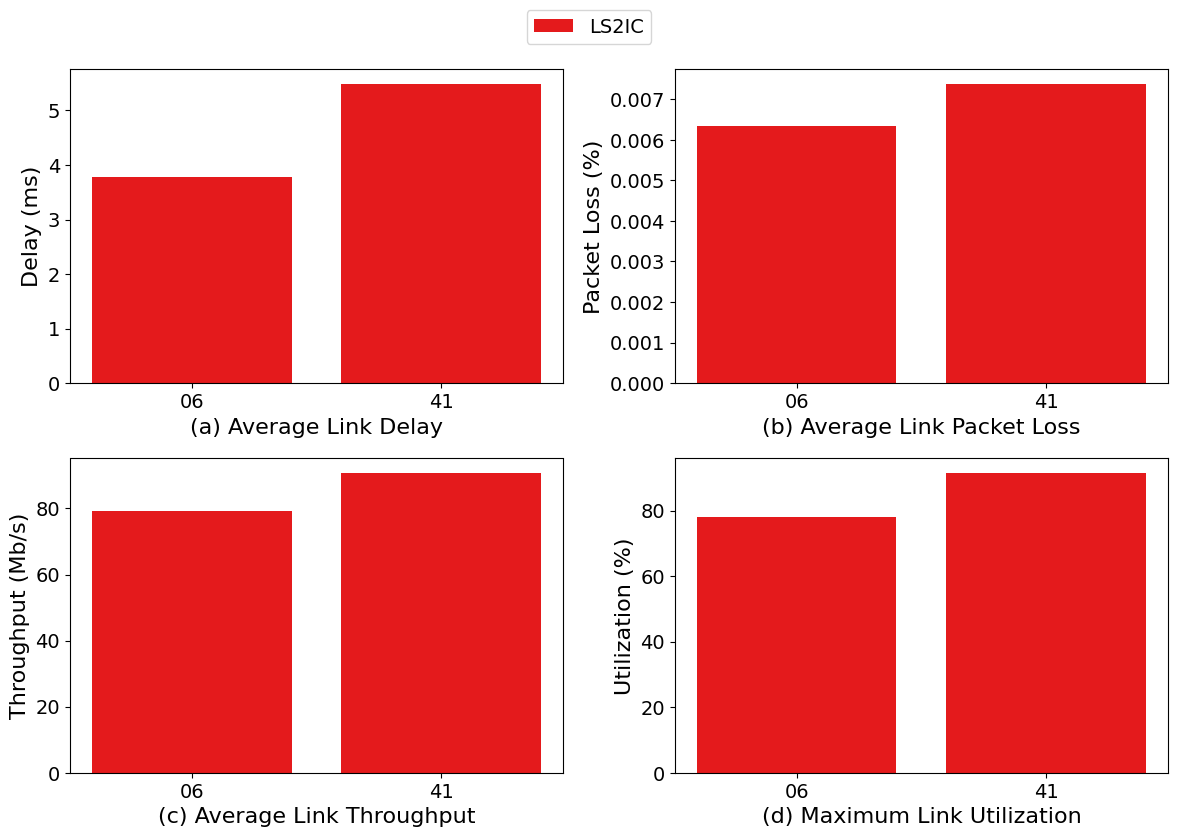

In [10]:
metrics_data = {alg: {} for alg in algorithm_dirs}

# 逐一讀取各個算法的 CSV 檔並計算各欄位平均值
for file in tm_files:
    tm_id = file.split("_")[0]  # 取得 TM 編號
    
    for alg, dir_path in algorithm_dirs.items():
        file_path = os.path.join(dir_path, file)
        try:
            df = pd.read_csv(file_path)
            metrics_data[alg][tm_id] = {
                "avg_delay": df["avg_delay"].mean(),
                "avg_packet_loss": df["avg_packet_loss"].mean(),
                "avg_throughput": df["avg_throughput"].mean(),
                "max_link_utilization": df["max_link_utilization"].mean()
            }
        except Exception as e:
            print(f"讀取 {file} ({alg}) 時出錯：", e)

# 印出結果以供檢查
for alg, data in metrics_data.items():
    print(f"Algorithm {alg} metrics:")
    print(data)

def plot_all_metrics(metrics_data):
    """
    繪製所有算法的四個指標，並且能夠適應不同數量的算法。
    """
    metrics = ["avg_delay", "avg_packet_loss", "avg_throughput", "max_link_utilization"]
    titles = ["(a) Average Link Delay", "(b) Average Link Packet Loss", "(c) Average Link Throughput", "(d) Maximum Link Utilization"]
    ylabels = ["Delay (ms)", "Packet Loss (%)", "Throughput (Mb/s)", "Utilization (%)"]
    
    tm_ids = sorted(next(iter(metrics_data.values())).keys(), key=lambda x: int(x))
    x = np.arange(len(tm_ids))  # X 軸刻度
    width = 0.8 / len(metrics_data)  # 動態調整柱狀圖寬度
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()
    
    colors = ["#E41A1C", "#377EB8", "#4DAF4A", "#FF7F00", "#984EA3", "#A65628"]
    
    for i, metric in enumerate(metrics):
        ax = axes[i]
        for j, (alg, data) in enumerate(metrics_data.items()):
            values = [data[tm][metric] for tm in tm_ids]
            ax.bar(x + (j - len(metrics_data)/2 + 0.5) * width, values, width, label=alg, color=colors[j % len(colors)])
        
        ax.set_xlabel(titles[i], fontsize=16)
        ax.set_ylabel(ylabels[i], fontsize=16)
        ax.set_xticks(x)
        ax.set_xticklabels(tm_ids, fontsize=14)
        ax.tick_params(axis='y', labelsize=14)
    
    fig.legend(metrics_data.keys(), loc='upper center', bbox_to_anchor=(0.5, 1.06), ncol=len(metrics_data.keys()), fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 1])
    plt.savefig("Figure 18. Testing result in 32-node 144TM.svg", format='svg', bbox_inches='tight')
    plt.show()

def compute_relative_improvements_no_avg(metrics_data):
    """
    不對 TM 做平均，而是對每個指標＆每個 TM 分別產生一個 5×5 (alg×alg) 的相對提升表。
    
    回傳結構: improvements_tables[metric][tm] = pd.DataFrame(alg x alg)
    表中儲存 (A 相較於 B 的 improvement %)
    """
    # 定義哪個指標「越低越好(lower)」，哪個「越高越好(higher)」
    metric_directions = {
        'avg_delay': 'lower',
        'avg_packet_loss': 'lower',
        'avg_throughput': 'higher',
        'max_link_utilization': 'lower'
    }

    metrics = list(metric_directions.keys())        # 4 個指標
    alg_list = list(metrics_data.keys())            # 5 個方法
    
    # 從第一個演算法中抓出 TM 編號 (如 06, 41, 73, 108, 141)
    example_alg = alg_list[0]
    tm_ids = sorted(metrics_data[example_alg].keys(), key=lambda x: int(x))

    # 最終存放所有表格的結構： {metric -> {tm -> df(5×5)}}
    improvement_tables = {}

    for metric in metrics:
        direction = metric_directions[metric]
        improvement_tables[metric] = {}  # 這個指標下，不同 TM 的表

        for tm in tm_ids:
            # 為此指標 & 此 TM 建立一個 5×5 的表 (row: algA, col: algB)
            df_improvement = pd.DataFrame(index=alg_list, columns=alg_list, dtype=float)

            for algA in alg_list:
                for algB in alg_list:
                    if algA == algB:
                        df_improvement.loc[algA, algB] = np.nan
                        continue
                    
                    valA = metrics_data[algA][tm][metric]
                    valB = metrics_data[algB][tm][metric]

                    # 避免分母=0 (若 valB=0，無法計算相對提升)
                    if valB == 0:
                        improvement = np.nan
                    else:
                        # lower: (valB - valA)/valB * 100  (A 值更低表示好)
                        # higher: (valA - valB)/valB * 100 (A 值更高表示好)
                        if direction == 'lower':
                            improvement = (valB - valA) / valB * 100.0
                        else:
                            improvement = (valA - valB) / valB * 100.0

                    df_improvement.loc[algA, algB] = improvement
            
            # 存起來
            improvement_tables[metric][tm] = df_improvement

    return improvement_tables

def print_improvement_tables_no_avg(improvement_tables):
    """
    將不做平均的相對提升結果 (4×{TM->5×5}) 一次列印出來。
    """
    for metric, tm_dict in improvement_tables.items():
        print(f"=== {metric} ===")
        for tm, df in tm_dict.items():
            print(f"--- TM = {tm} ---")
            print(df.to_string(float_format=lambda x: f"{x:6.2f}%"))
            print()

if __name__ == "__main__":
    win_tables = compute_relative_improvements_no_avg(metrics_data)
    print_improvement_tables_no_avg(win_tables)
    plot_all_metrics(metrics_data)